In [13]:
import numpy as np
import pandas as pd
from time import sleep 
from math import sqrt
from sklearn import svm
from sklearn import tree
import scipy.stats as scs
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

class Prometheus:
    
    def __init__(self):
        
        self.Stack = []
        self.Sample,self.Probes,self.Matrix = [],[],[]
        
    # Nettoyage de données
    def Parser(self,nameFile):
        
        count = 0
        File = open(nameFile,'r')
        File_O = open("GSE26835_Clean.data.txt",'w')
        
        for line in File:
            Temp = line.split()
            Final = [Temp[0]]
            String_O = ""
            
            if(count == 0):
                Final += [e for e in Temp[1:] if "hr" in e]
            
            else:
                Index = -1
                for i in range(1,len(Temp)):
                    if( i < 20 and Temp[i+1] == "like"):
                        continue
                    
                    elif( i < 20 and not '.' in Temp[i+1]):
                        continue
                        
                    else:
                        if ('.' in Temp[i]):
                            if(self.CheckFloat(Temp[i])):
                                Index = i
                                break
                        
                Final += Temp[Index:]
                
            for elem in Final:
                String_O += elem + " "
            String_O += "\n"
            File_O.write(String_O)
            
            count += 1
        
        File.close()
        File_O.close()
    
    def CheckFloat(self,numb):
        Check = True
        
        for e in numb:
            if(not e.isnumeric() and e != '.' ):
                Check = False
                break
                
        return Check
    
    # Ordonner les colonnes par heures croissante
    # Changer les NaN et les valeurs nég en 0
    def OrderMatrix(self):

        count = 0
        File = open("GSE26835_Clean.data.txt",'r')
        Output = open("GSE26835_OrderHourAndIncorrectValueFixed.data.txt","w")
        
        for line in File:
            Output_String = ""
            L = line.split()[:351]
            
            if(count == 0): self.Sample = L[1:]
            
            else:
                self.Probes.append(L[0])
                self.Matrix.append([float(e) for e in L[1:]])
            
            for elem in L:
                if(elem == "NaN" or '-' in elem): elem = "0"
                Output_String += elem + " "
            Output_String += "\n"
            Output.write(Output_String)
            count += 1
        
    #Quantile Normalization
    def partition(self,alist,first,last,row):
        
        pivotvalue = alist[first]
        leftmark = first+1
        rightmark = last
        done = False
    
        while not done:
            while leftmark <= rightmark and alist[leftmark] <= pivotvalue:
                leftmark = leftmark + 1

            while alist[rightmark] >= pivotvalue and rightmark >= leftmark:
                rightmark = rightmark -1

            if rightmark < leftmark: done = True
      
            else:
                temp = alist[leftmark]
                alist[leftmark] = alist[rightmark]
                alist[rightmark] = temp
                if( (row,leftmark) != (row,rightmark)):
                    self.Stack.append([(leftmark,row),(rightmark,row)])

        temp = alist[first]
        alist[first] = alist[rightmark]
        alist[rightmark] = temp
        if( (row,first) != (row,rightmark)):
            self.Stack.append([(first,row),(rightmark,row)])

        return rightmark

    def quickSortHelper(self,alist,first,last,row):
        if(first<last):
            splitpoint = self.partition(alist,first,last,row)
            self.quickSortHelper(alist,first,splitpoint-1,row)
            self.quickSortHelper(alist,splitpoint+1,last,row)

    def quickSort(self,alist,row):
        self.quickSortHelper(alist,0,len(alist)-1,row)

    def Normalize(self):
        
        matrix = []
        Output = open("GSE26835_Quantile.data.txt","w")
        self.Matrix = np.array(self.Matrix)
        self.Matrix = self.Matrix.transpose()

        
        
        for i in range(len(self.Matrix)):
            self.quickSort(self.Matrix[i],i)
            
        self.Matrix = self.Matrix.transpose()
        
        #Moyenne
        for i in range(len(self.Matrix)):
            m = 0
            
            for j in range(len(self.Matrix[i])): m += self.Matrix[i][j]
            m = m/len(self.Matrix[i])
            matrix.append([float(m) for k in range(len(self.Matrix[i]))])
       
        del(self.Matrix)
        
        for ind in range(-1,-len(self.Stack)-1,-1):
            e_1 = self.Stack[ind][0]
            o_1 = self.Stack[ind][1]
        
            matrix[e_1[0]][e_1[1]],matrix[o_1[0]][o_1[1]] = matrix[o_1[0]][o_1[1]],matrix[e_1[0]][e_1[1]]
    
        self.Stack = []
        
        String_O = "Probe "
        
        for e in self.Sample:
            String_O += e + " "
        String_O += "\n"
        
        Output.write(String_O)
        
        
        for i in range(len(matrix)):
            String_O = self.Probes[i] + " "
            for e in matrix[i]:
                String_O += str(e) + " "
            String_O += "\n"
            Output.write(String_O)
        
        del(self.Probes)
        Output.close()
    
    # T-Test pour retirer les données trop variables
    def Preprocessing_Test(self):
        
        count = 0
        File = open("GSE26835_Quantile.data.txt","r")
        Output = open("GSE26835_T_Test.data.txt","w")
        
        for line in File:
            
            Check = False
            Liste = line.split()
            String = ""
            
            if(count != 0):
                Liste_1 = [float(e) for e in Liste[1:208]]
                Liste_2 = [float(e) for e in Liste[208:]]
                a,b = self.T_Test(Liste_1,Liste_2)
                
                if( b <= 0.05): Check = True
                    
            if(count == 0 or Check):
                for e in Liste: String += e + " "
                String += "\n"
                Output.write(String)
            
            count += 1
           
        File.close()
        Output.close()
    
    def T_Test(self,L1,L2):
        
        mean_1 = np.average(L1)
        mean_2 = np.average(L2)
        
        n_1    = len(L1)
        n_2    = len(L2)
        
        var_1  = np.var(L1)
        var_2  = np.var(L2)
        
        num    = abs(mean_1 - mean_2)
        
        a      = (var_1) / n_1
        b      = (var_2) / n_2
        
        denom  = sqrt(a+b)
        
        t      = num / denom
        
        df     = n_1 + n_2 - 2
        
        p      = 2 * (1 - scs.t.cdf(t,df))
        
        return (t,p)

    def Evaluation(self,Y_test,y_prob):
        
        F_Plus,T_Plus,Seuil = roc_curve(Y_test,y_prob)
        roc_auc             = auc(F_Plus,T_Plus)
        
        # Plot the ROC graph
        
        plt.plot(F_Plus, T_Plus, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right")
        plt.show()
        
        return roc_auc
    
    def Training(self,mod,maxi):
        
        count = 0
        X,y = [],[]
        model = None
        File = open('GSE26835_T_Test.data.txt','r')
       
        if(mod == "SVML"):
            model = svm.SVC(probability=True,kernel='linear')
       
        elif(mod == "SVM"):
            model = svm.NuSVC(probability=True)
            
        elif(mod == "KNN"):
            model = KNeighborsClassifier(n_neighbors=3)
            
        elif(mod == "TREE"):
            model = tree.DecisionTreeClassifier()
            
        for line in File:
            if(count!= 0):
                Liste = line.split()[1:]
                h0 = sum([float(e) for e in Liste[1:208]])
                h6 = sum([float(e) for e in Liste[208:]])
                X.append([h0])
                y.append(0)
                X.append([h6])
                y.append(1)
    
            if(count == maxi): break
            count += 1
        File.close()
     
        x_train,X_test,y_train,Y_test = train_test_split(X,y,test_size = 0.33)
        model.fit(x_train,y_train)
        y_prob = model.predict_proba(X_test)[:,1]
        Pro = self.Evaluation(Y_test,y_prob) * 100

        print( mod, " = ", Pro, "%." )
        
        

In [14]:
Pro = Prometheus()

In [ ]:
Pro.Parser("GSE26835.data.txt")

In [ ]:
Pro.OrderMatrix()

In [ ]:
Pro.Normalize()

In [ ]:
Pro.Preprocessing_Test()

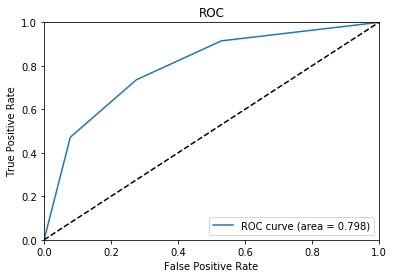

KNN  =  79.76560523475533 %.


In [17]:
Pro.Training("KNN",30000)